# Neural Vector Conceptualization for Word Vector Space Interpretation

@author: Lisa Raithel, mailto: first.lastname@dfki.de

## Preparation

Import all necessary modules from the underlying code base.

In [1]:
from models.nvc_model import NeuralVectorConceptualizer
from models.embeddings import Embedding

Using TensorFlow backend.


Ignore _UndefinedMetric_ warnings for a cleaner representation of the training procedure.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

## Data

### Create the dataset from scratch (optional)

Create the "raw data" TSV file from the original Microsoft Concept Graph [database](https://concept.research.microsoft.com/Home/Download).
The script (thanks to leonhard.hennig@dfki.de) calculates all scores as described in [Wang et al. (2015)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/scoring.pdf) and writes each instance and the associated scores to a tsv file.

*-infile*: path to the downloaded original data

*-outfile*: path to the file where you want to store the preprocessed data with REP scores

Unfortunately, due to some version updates, calculation of probabilities takes very long.
Until updated to Python3, we do not recommend to run this script.

The pre-calculated file is included in the repo accompanying this notebook (`data-concept-instance-relations-with-rep.tsv`).

From this, we created the JSON file `raw_data.json`. It holds the same information, but is faster to read. See instructions for creating the JSON file below.

In [4]:
# %run -i utils/ms_concept_graph_scoring.py -infile data/data-concept-instance-relations.txt -outfile data/data-with-rep.tsv

### Specify pre-processed data files

- the path to the already filtered data
- the path to the embedding vectors
- the configuration file

In [5]:
# the path to the already filtered data (on which our model was trained and tested)
path_to_filtered_data = "hidden2_1e-07-1e-07_2019_03_01-13_54_54/filtered_data_i100_v-10.json"
# the path to the word2vec vectors
embedding_file = "data/GoogleNews-vectors-negative300.bin.gz"
# the configuration file with which our model was trained
config = "hidden2_1e-07-1e-07_2019_03_01-13_54_54/config_hidden2_1e-07-1e-07_2019_03_01-13_54_54.json"

An example configuration file looks like this:

```json
{
  "batch_size": 128,
  "class_weights": true,      # use class weights 
  "classif_threshold": 0.5,   # a threshold for classification performance
  "cross_val": false,         # if you want to use cross validation, please add the number of folds
  "early_stopping": true,
  "epochs": 10,
  "mcg_file_header": ["concept", "instance", "count", "p(c|e)", "p(e|c)", "rep", "empty"],
  "min_num_inst": 100,        # the number of instances each concept has to have to be considered
  "min_rep": -10,             # the minimal REP value the instances of a concept need to have
  "num_hidden_layers": 2,     
  "only_unigrams": false,     # use either phrases (including unigrams) or only unigrams
  "regularizers": [0.000001, 0.000001],       # the L2 regularization factors for the hidden layers
  "train_set_size": 0.8       # the size of the training set when not using cross validation
}

```

To filter data for a new model, uncomment the cell below:

In [6]:
# the raw data in JSON format
# path_to_raw_data = "data/raw_data_dict.json"
# or the data in TSV format (when loading this file, a JSON is produced for further processing)
# path_to_raw_data = "data/data-concept-instance-relations-with-rep.tsv"
# the path to the word2vec vectors
# embedding_file = "data/GoogleNews-vectors-negative300.bin.gz"
# the configuration file with which our model was trained
# config = "my_config.json"

### Load necessary modules and data

- Load the embedding module and initialize the NVC model.

In [7]:
embedding = Embedding(embedding_file=embedding_file, voc_limit=None)
nvc = NeuralVectorConceptualizer(config_file=config, embedding=embedding)


Embedding loaded.


- Load the already filtered data with the given parameters

In [8]:
print("Minimum rep value: {}".format(nvc.config["min_rep"]))
print("Minimum number of instances: {}".format(nvc.config["min_num_inst"]))

Minimum rep value: -10
Minimum number of instances: 100


In [9]:
# load the already filtered data
nvc.load_data(path_to_data=path_to_filtered_data, filtered=True)

Loading existing filtered data file 'hidden2_1e-07-1e-07_2019_03_01-13_54_54/filtered_data_i100_v-10.json'.
shape filtered data (instances x concepts): (97660, 637)
Writing 2902340 instances not in embedding vocabulary to file 'words_not_in_mcg_i100_v-10.txt'.
Done.



- To load the raw data and filter them according to the parameters (minimal REP value and minimal number of instances) set in the configuration file, uncomment the cell below.

In [10]:
# load the raw data 
# nvc.load_data(path_to_data=path_to_raw_data, filtered=False)

- Furthermore, you can load only a subset of the data by specifying a list of concepts to filter:

In [11]:
# you can also select a subset of concepts to be filtered
# nvc.load_data(
#     path_to_data=path_to_raw_data,
#     filtered=False,
#     selected_concepts=["city", "province"])

- check if a certain word is part of the MCG data

In [12]:
word = "bumblebee"
print("'{}' in instances: {}".format(word, word in nvc.instances))

'bumblebee' in instances: True


## Load a pre-trained NVC model

Load a pre-trained model by specifying the path to the h5 file and the validation data.

In [13]:
# load a pre-trained model
model_path = "hidden2_1e-07-1e-07_2019_03_01-13_54_54/model_hidden2_1e-07-1e-07_2019_03_01-13_54_54.h5"
validation_data = "hidden2_1e-07-1e-07_2019_03_01-13_54_54/test_set_hidden2_1e-07-1e-07.csv"
nvc.load_pretrained_model(trained_model=model_path, x_val_file=validation_data)

Avrg #positive concepts per instance: 1.215216055703461
Loading pretrained model: 'hidden2_1e-07-1e-07_2019_03_01-13_54_54/model_hidden2_1e-07-1e-07_2019_03_01-13_54_54.h5'



## Train a new NVC model

To train a new NVC model, uncomment the cell below. The details for training are set in the configuration file.

In [14]:
# nvc.train()

## Results

### Activation Profiles 
Show the activation and cosine similarity profiles of the given words *listening*, *mafioso* and *Berlin*. You can try all words/phrases that are in the embedding's vocabulary.

<Figure size 432x288 with 0 Axes>

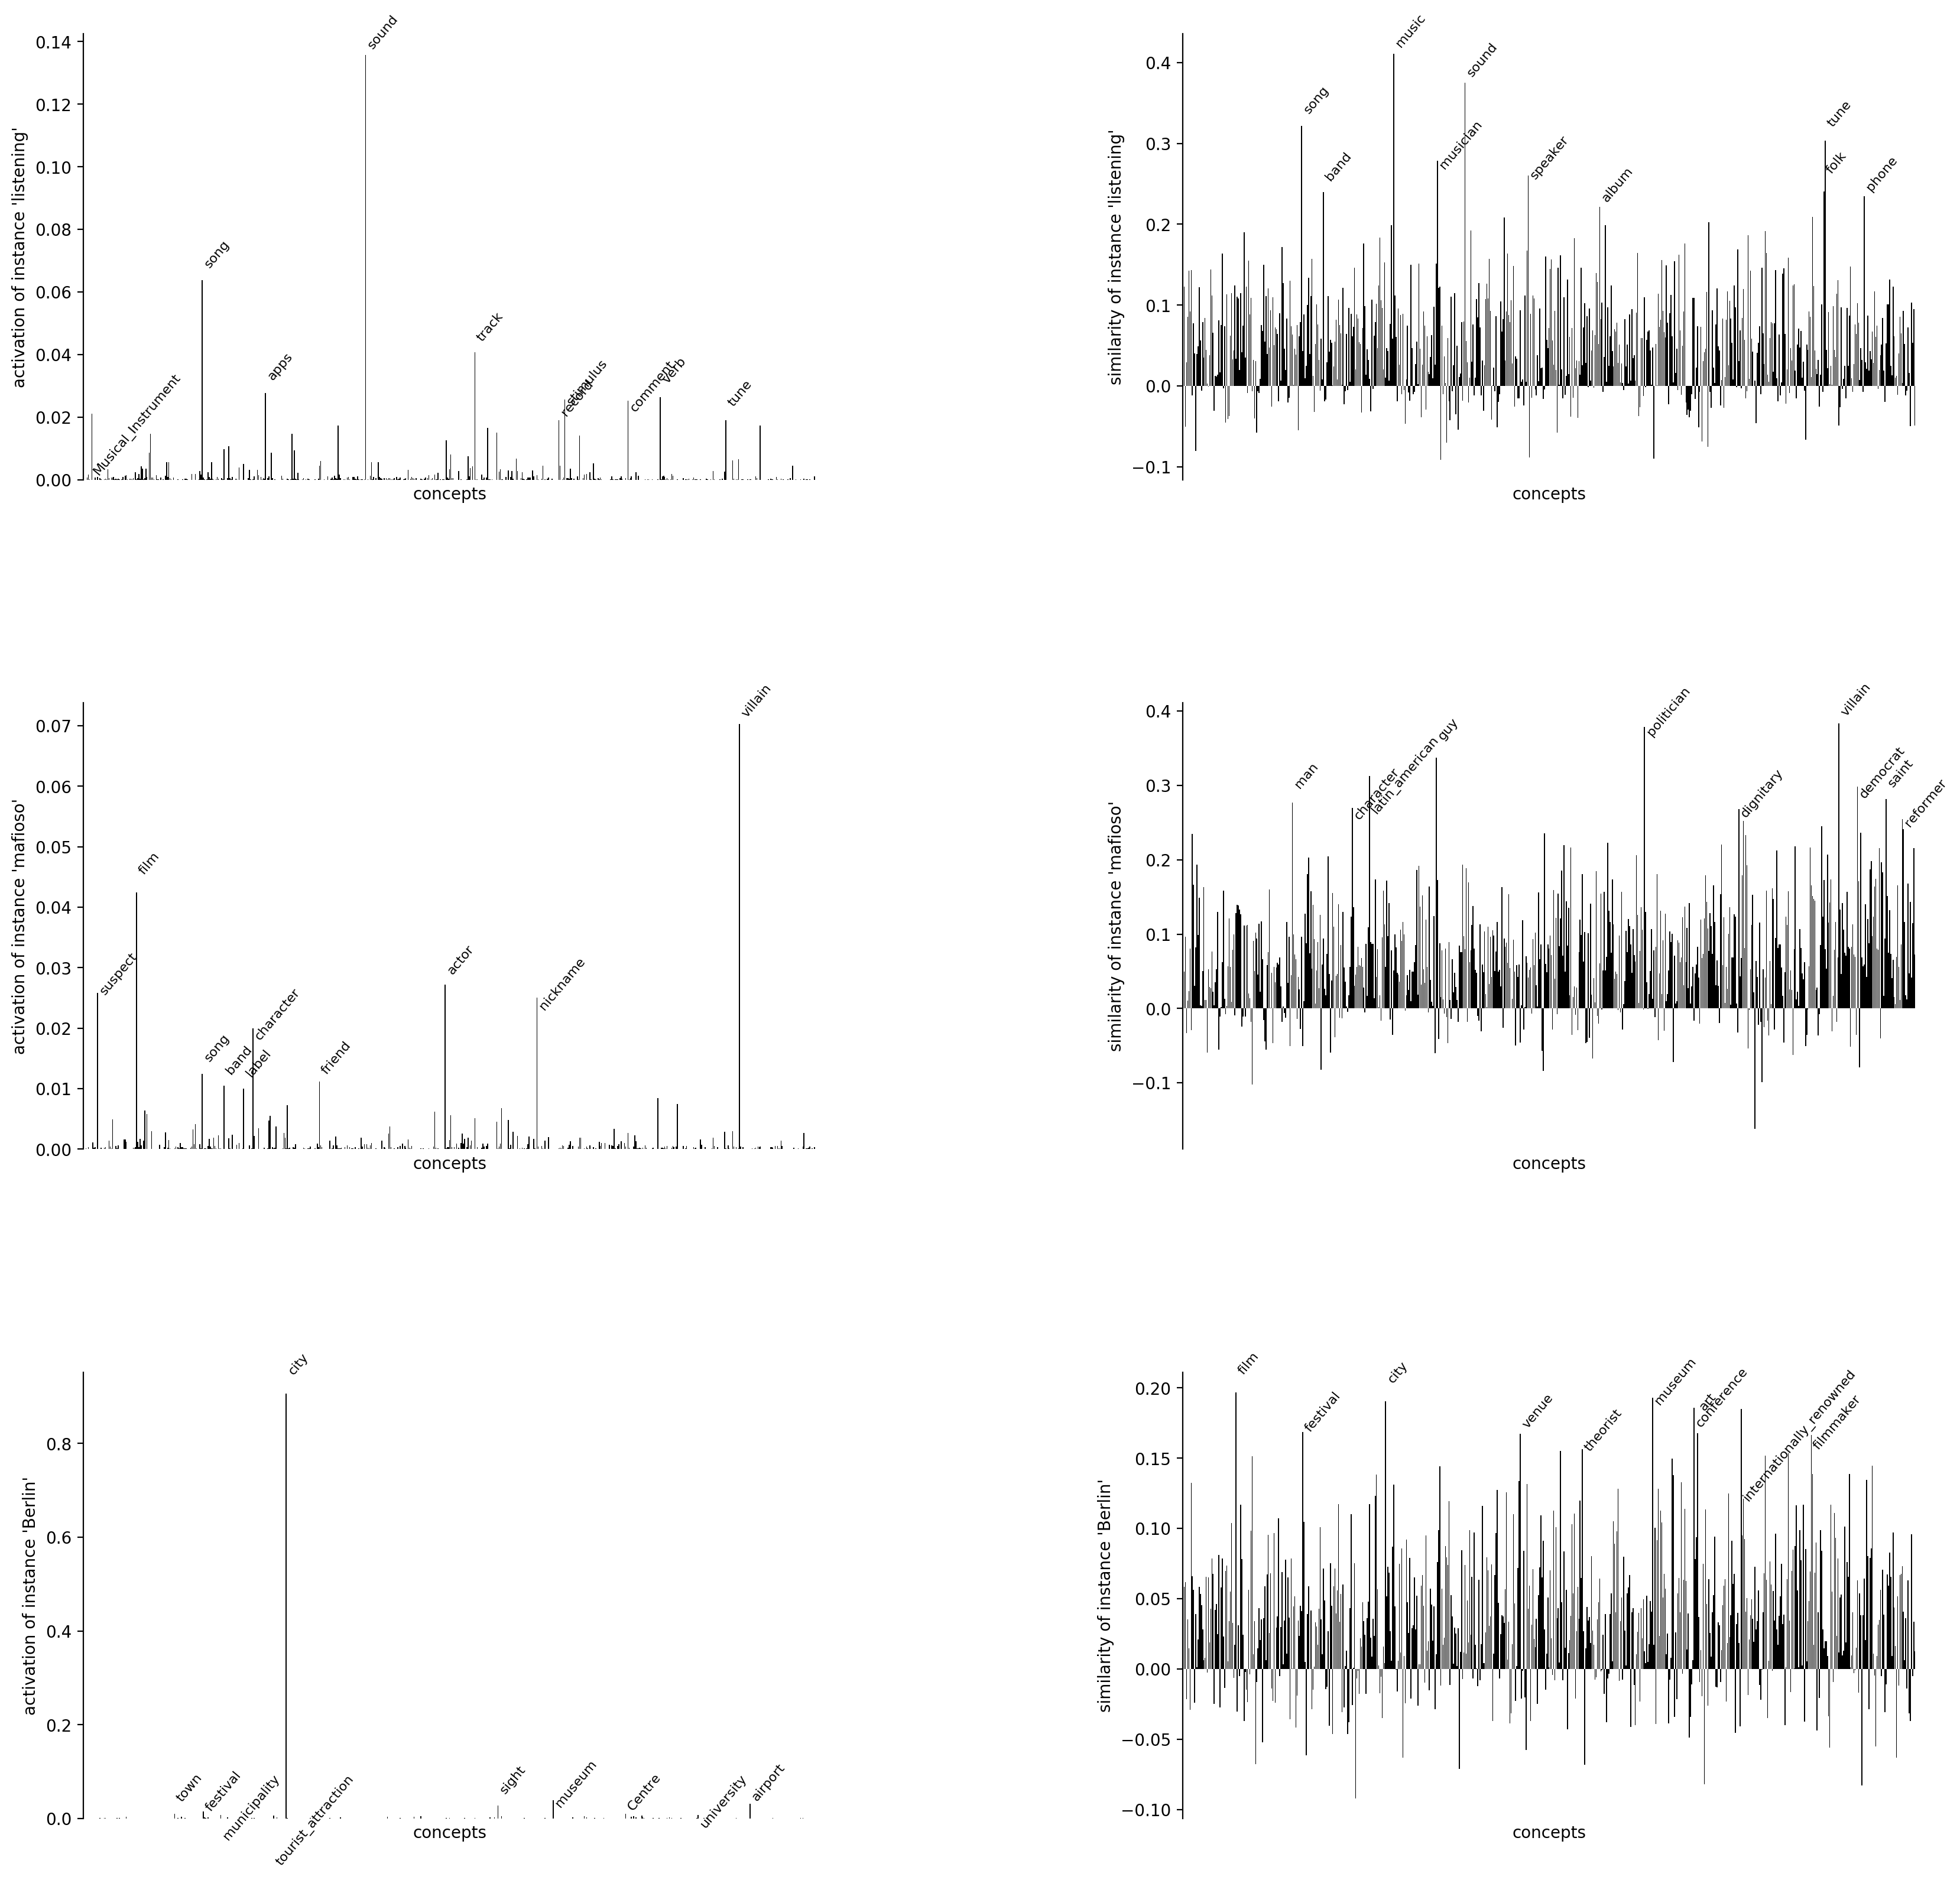

In [15]:
nvc.show_activations(["listening", "mafioso", "Berlin"], max_highlights=10)

### Per-Class Scores
Show a table with precision, recall and F1 scores for each concept.

In [16]:
nvc.get_results_per_class()

,concept,precision,recall,F1,support
0,file,0.000000,0.000000,0.000000,9
1,medication,0.648649,0.685714,0.666667,35
2,model,1.000000,0.071429,0.133333,14
3,item,0.666667,0.153846,0.250000,13
4,health_care,0.600000,0.187500,0.285714,16
5,snack,0.666667,0.166667,0.266667,12
6,player,0.833333,0.135135,0.232558,37
7,Musical_Instrument,1.000000,0.428571,0.600000,14
8,fighter,0.894737,0.459459,0.607143,37
9,bait,1.000000,0.125000,0.222222,8


### Averaged Scores
Show the averaged scores for all concepts.

In [17]:
nvc.get_average_results()

,score,weighted,macro,micro
0,Precision,0.429475,0.374496,0.617741
1,Recall,0.164430,0.137015,0.164430
2,F1,0.217720,0.183145,0.259726
